In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB
Connected oraDW_ANALYTICS


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DW_INS_TRANFER_FCT'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_INS_TRANFER_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_INS_TRANFER_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 6


In [20]:
df

,TXN_NO,SUB_BRANCH_KEY,SUB_BRANCH_CDE,ACCT_NO_1,ACCT_NO_2,CUSTOMER_KEY,CUSTOMER_CDE,PARTNER_CDE,SUB_SECTOR_CDE,DAO_KEY,...,SUB_PRODUCT_CDE,SUB_PRODUCT_NM,VALUE_DT,AMT,AMT_LCL,PROCESS_DT,REC_CREATE_DT,REC_UPDATE_DT,SALES_ID,SALES_NAME
0,-1,118,VN0011551,040007291592,020058699668,33172691,1971887,543354,1700,-1,...,Covid19,None,2020-03-26,2000000.0,2000000.0,2020-03-26,2020-03-27 10:02:25,2020-03-27 10:02:25,None,None
1,-1,118,VN0011551,040007291592,020058699668,33172691,1971887,543354,1700,-1,...,Covid19,None,2020-03-26,2000000.0,2000000.0,2020-03-26,2020-03-27 10:02:25,2020-03-27 10:02:25,None,None
2,FT20087D1J5V,276,VN0012962,VND-10001-8606-2962,020058699668,34024557,3501473,543354,1700,30138,...,Covid19,None,2020-03-27,100000.0,100000.0,2020-03-27,2020-03-28 09:25:49,2020-03-28 09:25:49,None,None
3,-1,118,VN0011551,040007291592,020058699668,33172691,1971887,543354,1700,-1,...,Covid19,None,2020-03-27,1600000.0,1600000.0,2020-03-27,2020-03-28 09:25:49,2020-03-28 09:25:49,None,None
4,-1,118,VN0011551,040007291592,020058699668,33172691,1971887,543354,1700,-1,...,Covid19,None,2020-03-27,1600000.0,1600000.0,2020-03-27,2020-03-28 09:25:49,2020-03-28 09:25:49,None,None
5,FT20087YZ8QT,118,VN0011551,040007291592,020058699668,33172691,1971887,543354,1700,-1,...,Covid19,None,2020-03-27,1600000.0,1600000.0,2020-03-27,2020-03-28 09:25:49,2020-03-28 09:25:49,None,None


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,TXN_NO,0.0,object,3,0.500000,"[-1, FT20087D1J5V, FT20087YZ8QT]"
1,SUB_BRANCH_KEY,0.0,int64,2,0.333333,"[118, 276]"
2,SUB_BRANCH_CDE,0.0,object,2,0.333333,"[VN0011551, VN0012962]"
3,ACCT_NO_1,0.0,object,2,0.333333,"[040007291592, VND-10001-8606-2962]"
4,ACCT_NO_2,0.0,object,1,0.166667,[020058699668]
5,CUSTOMER_KEY,0.0,int64,2,0.333333,"[33172691, 34024557]"
6,CUSTOMER_CDE,0.0,object,2,0.333333,"[1971887, 3501473]"
7,PARTNER_CDE,0.0,object,1,0.166667,[543354]
8,SUB_SECTOR_CDE,0.0,object,1,0.166667,[1700]
9,DAO_KEY,0.0,int64,2,0.333333,"[-1, 30138]"


In [22]:
df.describe()

,SUB_BRANCH_KEY,CUSTOMER_KEY,DAO_KEY,AMT,AMT_LCL
count,6.000000,6.000000e+00,6.000000,6.000000e+00,6.000000e+00
mean,144.333333,3.331467e+07,5022.166667,1.483333e+06,1.483333e+06
std,64.503230,3.477728e+05,12304.195226,7.054549e+05,7.054549e+05
min,118.000000,3.317269e+07,-1.000000,1.000000e+05,1.000000e+05
25%,118.000000,3.317269e+07,-1.000000,1.600000e+06,1.600000e+06
50%,118.000000,3.317269e+07,-1.000000,1.600000e+06,1.600000e+06
75%,118.000000,3.317269e+07,-1.000000,1.900000e+06,1.900000e+06
max,276.000000,3.402456e+07,30138.000000,2.000000e+06,2.000000e+06


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', 'PROCESS_DT'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
16,VALUE_DT,0.0,datetime64[ns],2,0.333333,"[2020-03-26T00:00:00.000000000, 2020-03-27T00:..."
17,AMT,0.0,float64,3,0.500000,"[2000000.0, 100000.0, 1600000.0]"
18,AMT_LCL,0.0,float64,3,0.500000,"[2000000.0, 100000.0, 1600000.0]"
19,PROCESS_DT,0.0,datetime64[ns],2,0.333333,"[2020-03-26T00:00:00.000000000, 2020-03-27T00:..."


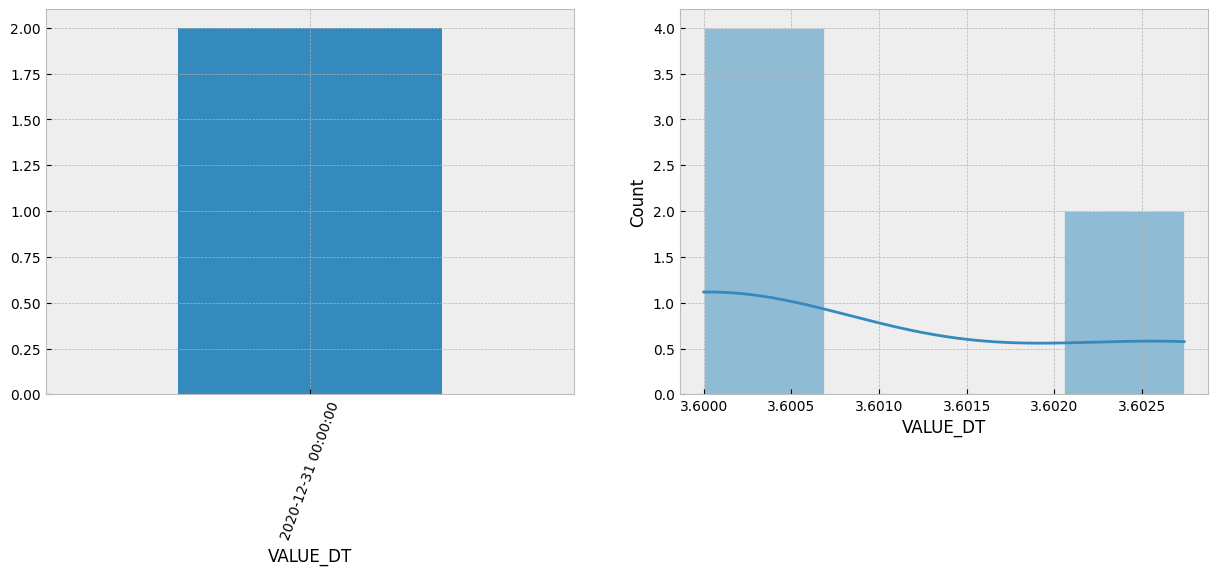

,default_func,remove_mode_value,logx
count,6.000,3.000,3.000
count_pct_chg,100.000,-50.000,-50.000
mean,1483333.333,1366666.667,13.510
mean_pct_chg,100.000,-7.865,-99.999
median,1600000.000,2000000.000,14.509
median_pct_chg,100.000,25.000,-99.999
min,100000.000,100000.000,11.513
min_pct_chg,100.000,0.000,-99.988
max,2000000.000,2000000.000,14.509
max_pct_chg,100.000,0.000,-99.999


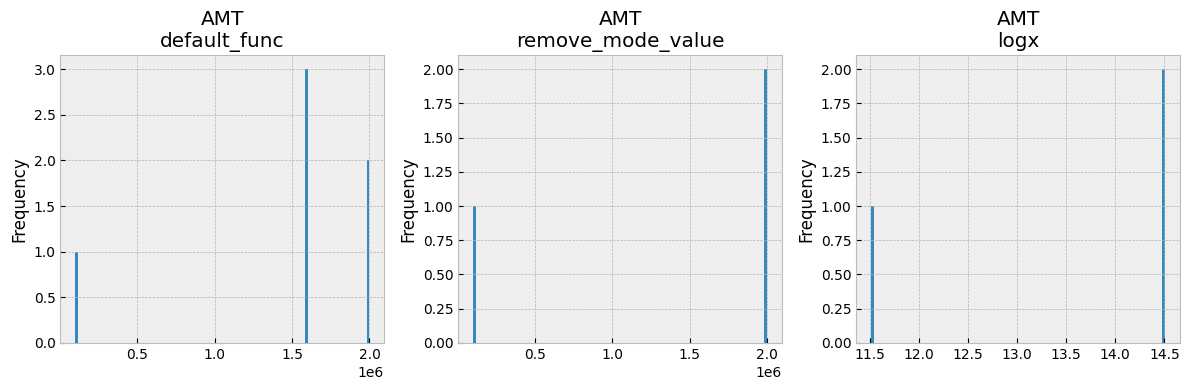

,default_func,remove_mode_value,logx
count,6.000,3.000,3.000
count_pct_chg,100.000,-50.000,-50.000
mean,1483333.333,1366666.667,13.510
mean_pct_chg,100.000,-7.865,-99.999
median,1600000.000,2000000.000,14.509
median_pct_chg,100.000,25.000,-99.999
min,100000.000,100000.000,11.513
min_pct_chg,100.000,0.000,-99.988
max,2000000.000,2000000.000,14.509
max_pct_chg,100.000,0.000,-99.999


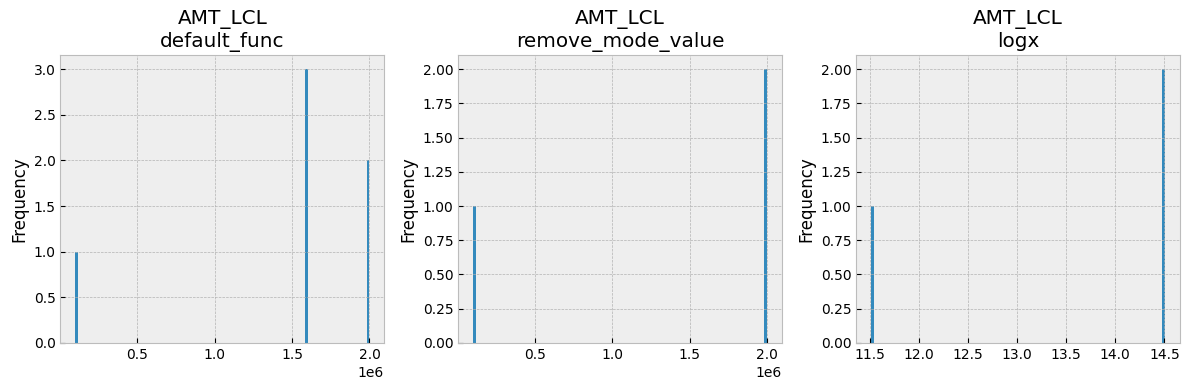

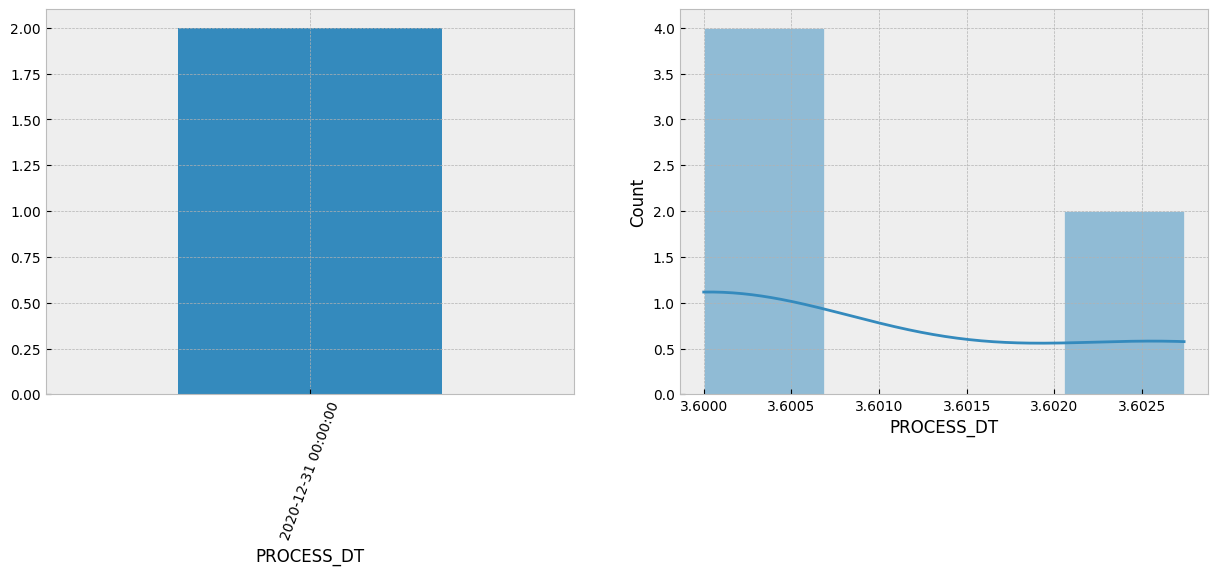

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['TXN_NO', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'ACCT_NO_1', 'ACCT_NO_2',
        'CUSTOMER_KEY', 'CUSTOMER_CDE', 'PARTNER_CDE', 'SUB_SECTOR_CDE',
        'DAO_KEY', 'DAO_CDE', 'CURRENCY_CDE', 'NARRATIVE', 'POLICY_NO',
        'SUB_PRODUCT_CDE', 'SUB_PRODUCT_NM', 'VALUE_DT', 'AMT', 'AMT_LCL',
        'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT', 'SALES_ID',
        'SALES_NAME'],
       dtype='object'),
 24)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['VALUE_DT', 'AMT', 'AMT_LCL', 'PROCESS_DT'], dtype='object', name='Column'),
 4)

In [27]:
df.columns

Index(['TXN_NO', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'ACCT_NO_1', 'ACCT_NO_2',
       'CUSTOMER_KEY', 'CUSTOMER_CDE', 'PARTNER_CDE', 'SUB_SECTOR_CDE',
       'DAO_KEY', 'DAO_CDE', 'CURRENCY_CDE', 'NARRATIVE', 'POLICY_NO',
       'SUB_PRODUCT_CDE', 'SUB_PRODUCT_NM', 'VALUE_DT', 'AMT', 'AMT_LCL',
       'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT', 'SALES_ID',
       'SALES_NAME'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3